# 1. Package preparation

In [281]:
#! pip install missingno
#! pip install geopy
# !pip install geopandas
# !pip install geoplot   # need conda install -c conda-forge cartopy 
# !pip install shapely
import numpy as np
import pandas as pd
import geopy
np.set_printoptions(threshold=np.inf)
from scipy import stats
import seaborn as sns
%matplotlib inline
from matplotlib.pylab import plt
%pylab inline
import missingno as msno 
import warnings # ignore the warnings
from geopandas import GeoDataFrame
import geopandas as gpd
from shapely.geometry import Point, Polygon
from geopy.geocoders import Nominatim
import geoplot as gplt
from string import ascii_letters
import seaborn as sns
import scipy.stats as ss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# 2. Data load

In [282]:
# upload the raw database
file = pd.read_csv('query_result_houses.csv')
file.shape

(9189, 64)

##### Delete meaningless columns

In [283]:
# delete meaningless columns
housing=file.iloc[:,0:51]
housing=housing.iloc[:,1:]
housing.head(5)

user_id country_id city_id city_name_input state_name_input community_id  \
0      41          0      11        New York               NY          NaN   
1      41         11      11        New York               NY          NaN   
2      41         11      11        New York               NY          NaN   
3      41          0     401        Lynnwood       Washington          NaN   
4      41          0      21         Seattle       Washington          NaN   

  zip_code house_type_id bedroom_count bathroom_count  ... dynamic_link area  \
0    10469             1             1              1  ...          NaN  NaN   
1    11419             1             1              1  ...          NaN  NaN   
2    10128             1             1              1  ...          NaN  NaN   
3    98087            21             2              1  ...          NaN  NaN   
4    98109             1             1              1  ...          NaN  NaN   

  rent_type_id video_url publisher_identity rent_duration deposit_amount  \
0          NaN       NaN                  0           NaN            NaN   
1          NaN       NaN                  0           NaN            NaN   
2          NaN       NaN                  0           NaN            NaN   
3          NaN       NaN                  0           NaN            NaN   
4          NaN       NaN                  0           NaN            NaN   

  language listing_key identity  
0      NaN         NaN      0.0  
1      NaN         NaN      0.0  
2      NaN         NaN      0.0  
3      NaN         NaN      0.0  
4      NaN         NaN      0.0  

[5 rows x 50 columns]

##### Delete all NaN columns and rows

In [284]:
# delete columns with all NaN
housing1 = housing.loc[:,~housing.isnull().all()]
# delete rows with all NaN
housing2 = housing1[~housing1.isnull().all(axis=1)]
housing2.shape

(9150, 50)

# 3. Data Cleaning
## 3.1 Missing values primary analysis

###### Missing Values Description Overview

In [285]:
missing_df = housing.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.sort_values(by='missing_count')
missing_df['missing_percentage'] = missing_df['missing_count']/len(housing)
# missing_df

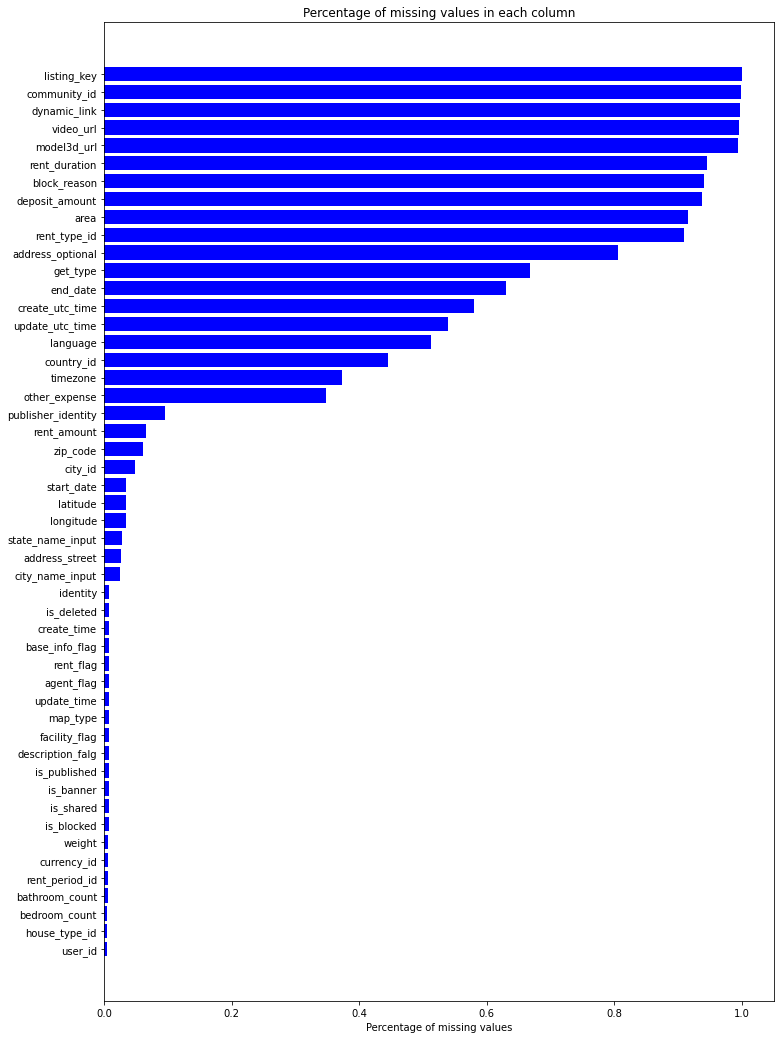

In [286]:
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_percentage.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Percentage of missing values")
ax.set_title("Percentage of missing values in each column")
plt.show()

## 3.2 Odd values anlaysis and modification
##### Cleaning odd rows with invalid User_ID
User Id is the key to indicate whether the record is unique or not, so we need to make sure that each user Id is a valid one. 

In [287]:
# delete some odd rows, depending on 'use_id'
print(sort(housing2['user_id'].unique()))

['  Ê¨¢ËøéÂ§ßÂÆ∂ÈöèÊó∂È¢ÑÁ∫¶ÁúãÊàøÔºÅ' ' End Unit' ' Water/Sewer. "' ' and Yoga Studio"'
 ' kitchen island with Insinkerator' ' ÂêÑÁ®Æ‰∏≠ÂºèÊ≥∞ÂºèË∂äÂºèÈüìÂºèÂç∞ÂºèÈ¶¨ÂºèÂ∑ùÂºèÁ≤µÂºèÂè∞ÂºèÈ§êÂª≥' ' Âæû‰∫ãÈáëËûç'
 ' ÁßüÊàø\\"„ÄÇ' '0' '1' '100002' '100021' '100081' '100141' '100161' '100182'
 '10031' '100411' '100552' '100571' '100611' '100681' '100741' '10091'
 '101' '10121' '101231' '101271' '101291' '10131' '101441' '101461'
 '101571' '101651' '101652' '101801' '101951' '102' '102021' '102052'
 '102071' '102332' '102362' '102491' '102492' '102502' '102712' '102811'
 '102851' '102872' '103002' '103012' '103021' '103162' '103202' '103241'
 '103242' '103262' '103312' '10351' '103612' '10371' '103741' '103751'
 '103771' '103901' '103952' '103982' '104121' '104161' '104212' '104231'
 '104242' '10431' '10441' '10451' '104512' '104562' '104762' '104822'
 '104921' '104922' '104951' '104991' '105001' '105101' '105291' '105301'
 '105321' '105481' '105541' '10591' '105971' '105972' '105982' '105

It is clear that some values are not normal. User Id should be made up with pure decimal numbers.   
Then, we store these weird values into a list, and we get rid of those matched rows since they are not valid.

In [288]:
# potential odd values
housing2['user_id'][housing2['user_id'].apply(lambda x: x.isdecimal()) == False]

898                                 ÁßüÊàø\"„ÄÇ
899                   2019-03-28 11:50:10
4220                          Ê¨¢ËøéÂ§ßÂÆ∂ÈöèÊó∂È¢ÑÁ∫¶ÁúãÊàøÔºÅ
4223                  2019-05-22 14:15:14
4404                  2019-06-11 15:53:41
6783                             End Unit
7038                             End Unit
7039                       Water/Sewer. "
7305                  2020-08-25 09:11:55
8509            20minsËªäÁ®ãÂà∞JFKÊ©üÂ†¥ ‚úàÔ∏èüß≥(Áñ´ÊÉÖÂõû‰∏ç‰∫ÜÂúã
8511               ÂêÑÁ®Æ‰∏≠ÂºèÊ≥∞ÂºèË∂äÂºèÈüìÂºèÂç∞ÂºèÈ¶¨ÂºèÂ∑ùÂºèÁ≤µÂºèÂè∞ÂºèÈ§êÂª≥
8512                                 Âæû‰∫ãÈáëËûç
8796     kitchen island with Insinkerator
8799                     and Yoga Studio"
Name: user_id, dtype: object

In [289]:
useidoddvalue = ['  Ê¨¢ËøéÂ§ßÂÆ∂ÈöèÊó∂È¢ÑÁ∫¶ÁúãÊàøÔºÅ','2019-06-11 15:53:41',' Water/Sewer. "','2020-08-25 09:11:55',
                 ' End Unit','2019-05-22 14:15:14', '2019-03-28 11:50:10',
                 '20minsËªäÁ®ãÂà∞JFKÊ©üÂ†¥ ‚úàÔ∏èüß≥(Áñ´ÊÉÖÂõû‰∏ç‰∫ÜÂúã', ' ÂêÑÁ®Æ‰∏≠ÂºèÊ≥∞ÂºèË∂äÂºèÈüìÂºèÂç∞ÂºèÈ¶¨ÂºèÂ∑ùÂºèÁ≤µÂºèÂè∞ÂºèÈ§êÂª≥', ' Âæû‰∫ãÈáëËûç',
                 ' kitchen island with Insinkerator', ' and Yoga Studio"',' ÁßüÊàø\\"„ÄÇ','2019-03-28 11:50:10']
useidoddindex = []
housing2.reset_index(drop=True, inplace=True)
for i in range(len(housing2)):
    #print(i)
    if housing2.iloc[i, :]['user_id'] in useidoddvalue:
        useidoddindex.append(i)
# Show those rows we deletes and check whether it is reasonable to delete
housing2.loc[useidoddindex,:]

user_id  \
893                               ÁßüÊàø\"„ÄÇ   
894                 2019-03-28 11:50:10   
4213                        Ê¨¢ËøéÂ§ßÂÆ∂ÈöèÊó∂È¢ÑÁ∫¶ÁúãÊàøÔºÅ   
4214                2019-05-22 14:15:14   
4390                2019-06-11 15:53:41   
6755                           End Unit   
7009                           End Unit   
7010                     Water/Sewer. "   
7276                2020-08-25 09:11:55   
8477          20minsËªäÁ®ãÂà∞JFKÊ©üÂ†¥ ‚úàÔ∏èüß≥(Áñ´ÊÉÖÂõû‰∏ç‰∫ÜÂúã   
8478             ÂêÑÁ®Æ‰∏≠ÂºèÊ≥∞ÂºèË∂äÂºèÈüìÂºèÂç∞ÂºèÈ¶¨ÂºèÂ∑ùÂºèÁ≤µÂºèÂè∞ÂºèÈ§êÂª≥   
8479                               Âæû‰∫ãÈáëËûç   
8759   kitchen island with Insinkerator   
8760                   and Yoga Studio"   

                                    country_id              city_id  \
893                                        NaN                  NaN   
894                                        NaN                  NaN   
4213                                       NaN                  NaN   
4214                                       NaN                  NaN   
4390                                       NaN                  NaN   
6755                         Insulated Windows          Master Bath   
7009                         Insulated Windows          Master Bath   
7010                                         0                  NaN   
7276                       2020-06-04 23:43:39  2020-08-25 16:11:55   
8477                           Âú®ÁæéÂúãÂ¢ÉÂÖßÊï£Êï£ÂøÉ‰πüÊòØÂøÖÈ†àÁöÑ!)                  NaN   
8478                                       ÁáíÁÉ§Â∫ó                  Â•∂Ëå∂Â∫ó   
8479                              Ê•µÂ∞ëÂá∫ÈñÄ (ÁÅ∞Â∏∏ÊÄïÊ≠ªüòÇ)                ÊÄßÊ†ºÂ•ΩÁõ∏Ëôï   
8759  gold faucet with 2 modes of water sprayÔøΩ                  NaN   
8760                                         0                  NaN   

          city_name_input                                   state_name_input  \
893                   NaN                                                NaN   
894                   NaN                                                  1   
4213                  NaN                                                NaN   
4214     America/New_York                                                  1   
4390     America/New_York                                                  1   
6755     Vaulted Ceilings                                    Walk-in Closet"   
7009     Vaulted Ceilings   Walk-in Closet Common Property Features: Elev...   
7010                    0                                                  0   
7276  America/Los_Angeles                                                  1   
8477                  NaN                                                NaN   
8478                   Âø´È§ê                                        Â§ßÂûã‰∫ûÊ¥≤Ë∂ÖÂ∏ÇÂíåÁæéÂúãË∂ÖÂ∏Ç   
8479               Ê≥®ÊÑèË°õÁîüÊï¥ÊΩî                                                NaN   
8759                  NaN                                                NaN   
8760                    1                                                  0   

           community_id zip_code house_type_id bedroom_count bathroom_count  \
893                 NaN      NaN           NaN           NaN            NaN   
894                 NaN      NaN             0           NaN            NaN   
4213                NaN      NaN           NaN           NaN            NaN   
4214                NaN      NaN             0           NaN            NaN   
4390                NaN      NaN             0           NaN            NaN   
6755                  0        0             0             0              1   
7009   Fire Sprinklers       NaN           NaN           NaN            NaN   
7010                  0        1             1             1              0   
7276                NaN      NaN             0           NaN            NaN   
8477                NaN      NaN           NaN           NaN            NaN   
8478                ‰æøÂà©Â∫ó     

We can see that these records are indeed with a lot of missing values, or unmatching meaningless information. Therefore, we can just drop them.

In [290]:
# Drop those rows
housing3 = housing2.drop(useidoddindex)
housing3['user_id'].unique()
housing3.reset_index(drop=True, inplace=True)

## 3.3 Filling in Geo information
The reason we are using the geo information is that we need to select out the data which country is the United States. We are only studying on the rent in the U.S.. However, since the country ID is missing about 44.29%, it's hard to use it as a filtering qriteria. Therefore, we choose to use longtitude and latitude, which are only missing 2.95%, to extract the geographic information by using the Geopy library. The Geopy library will generate the Country, City and zipcode according to the longtitude and latitude. This process will also help us to fill in some missing values in the variables of city_name_input, state_name_input, timezone and zipcode.

In [291]:
# we need to both longtitude and latitude to use the geopy function 
# we only choose those with non-nan longitude and latitude
housing4 = housing3[~(housing3['longitude'].isnull() |housing3['latitude'].isnull())]

Also, similar to what we did with the user id, we need to find out if there is any weird record in the longtitude or latitude columns. The values should be able to convert to float, otherwise, we need to be careful of those which can't be converted.

In [292]:
# find all improper longitude and latitude data
def checktype(x):
    try:
        float(x) 
        res = True
    except : 
        res = False
    return res

housing4['longitude'][housing4['longitude'].apply(lambda x: checktype(x)) == False]

454     2017-12-25 15:18:56
633     2018-01-16 16:19:45
894     2018-02-25 23:43:27
1586    2018-06-09 11:49:30
5170    2019-10-04 18:50:02
8468    2020-10-27 05:05:19
Name: longitude, dtype: object

In [293]:
housing4['latitude'][housing4['latitude'].apply(lambda x: checktype(x)) == False]

454     2018-03-04 15:55:37
633     2018-04-08 16:11:30
894     2019-03-06 23:49:02
1586    2018-06-09 11:59:53
5170    2019-10-04 19:04:05
8468    2020-10-27 05:12:50
Name: latitude, dtype: object

We could see that some date type objects are mixed into the longtitude and latitude values. We need to drop these rows.

In [294]:
lloddvalue = ['2017-12-25 15:18:56', '2018-01-16 16:19:45','2018-02-25 23:43:27','2018-06-09 11:49:30','2020-10-27 05:05:19']
lloddindex = []
housing4.reset_index(drop=True, inplace=True)
for i in range(len(housing4)):
    #print(i)
    if housing4.iloc[i, :]['longitude'] in lloddvalue:
        lloddindex.append(i)

housing5 = housing4.drop(lloddindex)

# housing5['longitude'].unique()
housing5.reset_index(drop=True, inplace=True)

##### Geopy
Now, we are creating four new columns to record the geographic information we gained from longtitude and latitude. These columns can also replace the city_name_input, state_name_input and zipcode columns.

In [295]:
'''Here are the codes for geo part, we just comment it because it would take a long time to interate
# We have saved the result in the following cvs file.'''

## initiazlie four new columns
# housing5['Country_geo'] = 0
# housing5['City_geo'] = 0
# housing5['State_geo'] = 0
# housing5['Postcode_geo'] = 0
# geolocator = Nominatim(user_agent = 'user_agent')

#for i in range(len(housing5)):
#    Latitude = housing5.iloc[i, :]['latitude']
#    Longitude = housing5.iloc[i, :]['longitude']
#    location = geolocator.reverse(Latitude+","+Longitude) 
#    address = location.raw['address'] 
#    housing5['City_geo'][i] = address.get('city', '') 
#    housing5['State_geo'][i] = address.get('state', '') 
#    housing5['Country_geo'][i] = address.get('country', '') 
#    # code = address.get('country_code') 
#    housing5['Postcode_geo'][i] = address.get('postcode') 
    
## Drop odd rows with meaningless location info (middle in the ocean)
#lloddindex2 = [1087, 1796, 1836, 1844, 2404, 2423, 2478, 4626, 5134, 5786, 8660]
##print(len(housing5))
#housing6 = housing5.drop(lloddindex2)
##print(len(housing6))
#housing6.reset_index(drop=True, inplace=True)

'Here are the codes for geo part, we just comment it because it would take a long time to interate\n# We have saved the result in the following cvs file.'

#### Store the clearned file into a new csv
Since the geopy function takes a long time to iterate through the dataframe, we saved/cached this new dataframe into a new csv file for further data processing and modelling. 

In [296]:
# housing6.to_csv("query_result_houses_withgeoinfo1.csv",index=False,sep=',')

##### Choose only US data
Filter by country = "United States". 
Now we have the new dataset, we only need the data which records the rent in the United States.

In [297]:
housing7 = pd.read_csv('query_result_houses_withgeoinfo1.csv')
UShousing = housing7[housing7['Country_geo'] == 'United States']
UShousing.shape

(8206, 54)

##### Geographic information complementation
We could see that geopy sometimes generate NA values for city names, whereas the city_name_input luckily has it for filling. And sometimes the city_name_inputs are in Chinese or NA, but we also luckily to have the city_geo which generated by geopy to fill those in. 

##### Fill in the Known missing value of Geographic information

In [298]:
UShousing1 = UShousing
UShousing1.shape

(8206, 54)

In [299]:
UShousing1.loc[(UShousing1['City_geo'].isnull() == True) & (UShousing1['city_name_input'].isnull() == False),"city_name_input"].unique()

array(['Lynnwood', 'Daly City', 'Kirkland', 'Schererville', 'Bethpage',
       'Westbury', 'Orlando', 'Mercer Island', 'Brookline', 'Kenmore',
       'Seattle', 'Á∫ΩÂç°ÊñØÂ∞î', 'Auburn', 'West Lafayette', 'Davis', 'Bothell',
       'Redmond', 'Seattle ', 'Dublin', 'East Palo Alto', 'San Gabriel',
       'Pleasant Hill', 'San Jose', 'Rochester', 'Issaquah', 'Ë•øÊãâÊ≥ïÂè∂',
       'Sammamish', 'Hoboken', 'West Lafayette ', 'Tukwila',
       'West Covina', 'Waltham', 'Alhambra', 'Diamond Bar', 'Malden',
       'Castro Valley', 'Somerville', 'Moore', 'Rowland Heights',
       'Union City', 'Santee', 'Edmonds', 'Arcadia', 'Medford',
       'Harrison', 'San Leandro', 'San Lorenzo', 'Rosemead',
       'Chino Hills', 'Evanston', 'Union city', 'West New York',
       'Emeryville', 'Burien', 'Amherst', 'Placentia', 'Las Vegas',
       'San Diego', 'Puyallup', 'Monterey Park', 'Walnut', 'Ê¥õÊùâÁü∂',
       'Richmond', 'Woodinville', 'Kent ', 'Floral Park', 'Mukilteo',
       'Elmwood Park', 'El C

In [300]:
UShousing1.loc[(UShousing1['City_geo'].isnull() == True) 
               & (UShousing1['city_name_input'].isnull() == False),
               "City_geo"]=UShousing1.loc[(UShousing1['City_geo'].isnull() == True) 
               & (UShousing1['city_name_input'].isnull() == False), "city_name_input"]

There are Chinese, so we may need to hardcode them into English 

In [301]:
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
        res = True
    except UnicodeDecodeError:
        res =  False 
    return res

In [302]:
# Get the celles with Chinese character
UShousing1.loc[UShousing1.loc[:,'City_geo'].apply(lambda x: isEnglish(str(x))) == False,"City_geo"].unique()

array(['Á∫ΩÂç°ÊñØÂ∞î', 'Ë•øÊãâÊ≥ïÂè∂', 'Ê¥õÊùâÁü∂', 'ÊóßÈáëÂ±±', 'Ê†∏Ê°ÉÂ∏Ç', 'ÈòøËãèËê®', 'Kirkland ÊüØÂÖãÂÖ∞', 'Ê≥¢Â£´È°ø',
       'Èõ∑Âæ∑ËíôÂæ∑', 'Ë•øÈõÖÂõæ', 'Á±≥Â∞îÂÖãÈáåÂÖã', 'Â§©ÊôÆÂ∏Ç', 'ËææÂãíÂßÜ', 'ÊüØÂÖãÂÖ∞', 'Êà¥Âà©Âüé', '‰ºäËê®Â§∏', 'Â∑¥Â∞îÁöÑÊë©Â∏Ç',
       'Â∏åÂ∞îÊñØ‰ºØÂãí', 'ÊûóÊÅ©‰ºçÂæ∑', 'Â•áËØ∫Â≤ó', 'ÈòøÁΩïÂ∏ÉÊãâ', 'ÁΩóÂÖ∞È´òÂú∞', 'ËíôÂ∏Ç', 'Êûó‰ºçÂæ∑', 'Êà¥Áª¥ÊñØ', 'Êüî‰ººËúú',
       'Â§ö‰º¶Â§ö', 'Ê¥õÊùâÁü∂ upland', 'ÈòøÂç°Ëø™‰∫ö', 'ËøàÈòøÂØÜ', 'Â∏ùÂà©Â∏Ç', 'Á∫ΩÁ∫¶ÊõºÂìàÈ°ø', 'ÂçöÂ°ûÂ∞î'],
      dtype=object)

In [303]:
di = {'Á∫ΩÂç°ÊñØÂ∞î': "Newcastle", 'Ë•øÊãâÊ≥ïÂè∂': "West Lafayette",'Ê¥õÊùâÁü∂':"Los Angeles", 'ÊóßÈáëÂ±±': "San Fransisco", 'Ê†∏Ê°ÉÂ∏Ç' : "Walnut City",
      'ÈòøËãèËê®' :'Asusa', 'Kirkland ÊüØÂÖãÂÖ∞' : "Kirkland", 'Ê≥¢Â£´È°ø' : "Boston",
       'Èõ∑Âæ∑ËíôÂæ∑':'Redmond', 'Ë•øÈõÖÂõæ' : 'Seattle', 'Á±≥Â∞îÂÖãÈáåÂÖã' :'Mill creek', 'Â§©ÊôÆÂ∏Ç' :'Temple City', 'ËææÂãíÂßÜ' :'Durham', 
      'ÊüØÂÖãÂÖ∞' : 'Kirkland', 'Êà¥Âà©Âüé' : 'Daly City', '‰ºäËê®Â§∏':'Isakwa', 'Â∑¥Â∞îÁöÑÊë©Â∏Ç':"Baltimore",
       'Â∏åÂ∞îÊñØ‰ºØÂãí':'Hillsboro', 'ÊûóÊÅ©‰ºçÂæ∑':'Lynnwood', 'Â•áËØ∫Â≤ó':'Chino hills', 'ÈòøÁΩïÂ∏ÉÊãâ':'Alhambra', 'ÁΩóÂÖ∞È´òÂú∞':'Roland Heights', 
      'ËíôÂ∏Ç':'Monterey park', 'Êûó‰ºçÂæ∑':'Linwood', 'Êà¥Áª¥ÊñØ':'Davis', 'Êüî‰ººËúú':'Rosemead',
       'Â§ö‰º¶Â§ö' :"Toronto", 'Ê¥õÊùâÁü∂ upland':"Los Angeles", 'ÈòøÂç°Ëø™‰∫ö' :'Arcadia', 'ËøàÈòøÂØÜ' :'Miami', 'Â∏ùÂà©Â∏Ç' :'Dili', 
      'Á∫ΩÁ∫¶ÊõºÂìàÈ°ø':'Manhattan','ÂçöÂ°ûÂ∞î':'Bothell' }

UShousing1.replace({"City_geo": di},inplace = True)
# UShousing1.loc[:,'City_geo'].unique()

Fill-in the missing Postcode_geo from Zipcode

In [304]:
UShousing1.loc[(UShousing1['Postcode_geo'].isnull() == True) & (UShousing1['zip_code'].isnull() == False),"zip_code"].unique()

array(['92127', '98109', '11355', '98101', '98052', '1000111', '97531',
       '91709', '2134', '90005', '94523', '2115', '10009', '98087',
       '98075', '92122', '98105', '10025', '48105', '10018', '2', '98103',
       '64803', '98004', '98005'], dtype=object)

In [305]:
UShousing1.loc[(UShousing1['Postcode_geo'].isnull() == True) & (UShousing1['zip_code'].isnull() == False),
               "Postcode_geo"] = UShousing1.loc[(UShousing1['Postcode_geo'].isnull() == True) & (UShousing1['zip_code'].isnull() == False),
               "zip_code"] 

Fill in the State_geo with State_name_input

In [306]:
UShousing1.loc[(UShousing1['State_geo'].isnull() == True) & (UShousing1['state_name_input'].isnull() == False),"state_name_input"].unique()

array(['Á∫ΩÁ∫¶'], dtype=object)

In [307]:
UShousing1.loc[(UShousing1['State_geo'].isnull() == True) & (UShousing1['state_name_input'].isnull() == False),"State_geo"] = "New York"

In [308]:
UShousing1 = UShousing1.drop(['city_id','country_id','city_name_input','zip_code','state_name_input','address_street','other_expense'], axis=1)
UShousing1.head(10)

user_id  community_id  house_type_id  bedroom_count  bathroom_count  \
0        41           NaN            1.0            1.0             1.0   
1        41           NaN            1.0            1.0             1.0   
2        41           NaN            1.0            1.0             1.0   
3        41           NaN           21.0            2.0             1.0   
4        41           NaN            1.0            1.0             1.0   
18      101           NaN            1.0            1.0             1.0   
19      131           NaN            1.0            2.0             1.9   
29      271           NaN           21.0            6.0             4.0   
42     1261           NaN           31.0            1.0             1.0   
43     1261           NaN           31.0            1.0             1.0   

     longitude   latitude                 address_optional  start_date  \
0   -73.857997  40.862775                           ÁΩóÂàáÊñØÁâπÂ§ßÂ≠¶  2017-09-25   
1   -73.827866  40.693742                    ElmhurstÂú∞ÈìÅÁ´ôÈôÑËøë  2017-09-25   
2   -73.951277  40.780365  Âì•Â§ßÈôÑËøë111Ë°ó Broadway & AmsterdamÁõ¥Êé•  2017-09-25   
3  -122.269401  47.848989                              NaN  2017-10-01   
4  -122.356307  47.647601                              NaN  2017-10-01   
18  -84.439526  33.817098                             1505  2017-09-25   
19 -122.297481  47.722173                              NaN  2017-06-25   
29  -94.717234  38.921708                              NaN  2017-09-29   
42 -122.415487  37.704823                              NaN  2017-10-25   
43 -122.415470  37.704703                              NaN  2017-10-25   

      end_date  ...  publisher_identity  rent_duration  deposit_amount  \
0          NaN  ...                 0.0            NaN             NaN   
1          NaN  ...                 0.0            NaN             NaN   
2          NaN  ...                 0.0            NaN             NaN   
3          NaN  ...                 0.0            NaN             NaN   
4          NaN  ...                 0.0            NaN             NaN   
18         NaN  ...                 0.0            NaN             NaN   
19  2017-10-25  ...                 0.0            NaN             NaN   
29         NaN  ...                 0.0            NaN             NaN   
42         NaN  ...                 0.0            NaN             NaN   
43         NaN  ...                 0.0            NaN             NaN   

   language listing_key identity    Country_geo       City_geo   State_geo  \
0       NaN         NaN      0.0  United States       New York    New York   
1       NaN         NaN      0.0  United States       New York    New York   
2       NaN         NaN      0.0  United States       New York    New York   
3       NaN         NaN      0.0  United States       Lynnwood  Washington   
4       NaN         NaN      0.0  United States        Seattle  Washington   
18      NaN         NaN      0.0  United States        Atlanta     Georgia   
19      NaN         NaN      0.0  United States        Seattle  Washington   
29      NaN         NaN      0.0  United States  Overland Park      Kansas   
42      NaN         NaN      0.0  United States      Daly City  California   
43      NaN         NaN      0.0  United States      Daly City  California   

   Postcode_geo  
0       10467.0  
1       11419.0  
2       10128.0  
3       98087.0  
4       98109.0  
18      30318.0  
19      98125.0  
29      66210.0  
42        94014  
43        94014  

[10 rows x 47 columns]

# 3.3 Other data cleaning for each column

##### Drop the the columns that have more than 55% missing values
We will try to fill in the missing valus for those columns that have less than 50% missing values.

In [309]:
missing_df = UShousing1.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
#missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df['missing_percentage'] = missing_df['missing_count']/len(UShousing1)
missing_df

column_name  missing_count  missing_percentage
0              user_id              0            0.000000
43         Country_geo              0            0.000000
3        bedroom_count              0            0.000000
4       bathroom_count              0            0.000000
5            longitude              0            0.000000
6             latitude              0            0.000000
45           State_geo              0            0.000000
44            City_geo              1            0.000122
46        Postcode_geo              2            0.000244
2        house_type_id              2            0.000244
11      rent_period_id              3            0.000366
12         currency_id              4            0.000487
13          is_blocked             11            0.001340
23          agent_flag             13            0.001584
32            map_type             13            0.001584
28         update_time             13            0.001584
16           is_banner             13            0.001584
17              weight             13            0.001584
18           is_shared             13            0.001584
19      base_info_flag             13            0.001584
21       facility_flag             13            0.001584
22    description_falg             13            0.001584
26          is_deleted             14            0.001706
27         create_time             14            0.001706
20           rent_flag             14            0.001706
15        is_published             14            0.001706
42            identity             17            0.002072
8           start_date             76            0.009262
10         rent_amount            272            0.033146
37  publisher_identity            688            0.083841
31            timezone           2725            0.332074
40            language           4164            0.507434
30     update_utc_time           4458            0.543261
29     create_utc_time           4813            0.586522
9             end_date           4928            0.600536
24            get_type           5539            0.674994
7     address_optional           6663            0.811967
35        rent_type_id           7485            0.912137
34                area           7545            0.919449
39      deposit_amount           7662            0.933707
14        block_reason           7689            0.936997
38       rent_duration           7736            0.942725
25         model3d_url           8165            0.995004
36           video_url           8178            0.996588
33        dynamic_link           8187            0.997685
41         listing_key           8203            0.999634
1         community_id           8206            1.000000

In [310]:
UShousing1 = UShousing1.drop(['create_utc_time','end_date','get_type', 'address_optional', 
                'rent_type_id','area','deposit_amount','block_reason', 'model3d_url', 
                'video_url','dynamic_link','listing_key','community_id'], axis=1)
UShousing1.reset_index(drop=True, inplace=True)
UShousing1.head(10)

user_id  house_type_id  bedroom_count  bathroom_count   longitude  \
0       41            1.0            1.0             1.0  -73.857997   
1       41            1.0            1.0             1.0  -73.827866   
2       41            1.0            1.0             1.0  -73.951277   
3       41           21.0            2.0             1.0 -122.269401   
4       41            1.0            1.0             1.0 -122.356307   
5      101            1.0            1.0             1.0  -84.439526   
6      131            1.0            2.0             1.9 -122.297481   
7      271           21.0            6.0             4.0  -94.717234   
8     1261           31.0            1.0             1.0 -122.415487   
9     1261           31.0            1.0             1.0 -122.415470   

    latitude  start_date  rent_amount  rent_period_id  currency_id  ...  \
0  40.862775  2017-09-25       1500.0             2.0          1.0  ...   
1  40.693742  2017-09-25        900.0             2.0          1.0  ...   
2  40.780365  2017-09-25         45.0             1.0          1.0  ...   
3  47.848989  2017-10-01       2040.0             2.0          1.0  ...   
4  47.647601  2017-10-01       1000.0             2.0          1.0  ...   
5  33.817098  2017-09-25        500.0             2.0          1.0  ...   
6  47.722173  2017-06-25       5888.0             2.0          1.0  ...   
7  38.921708  2017-09-29        600.0             2.0          1.0  ...   
8  37.704823  2017-10-25          0.0             2.0          1.0  ...   
9  37.704703  2017-10-25       1200.0             2.0          1.0  ...   

  timezone map_type publisher_identity rent_duration language identity  \
0      NaN        1                0.0           NaN      NaN      0.0   
1      NaN        1                0.0           NaN      NaN      0.0   
2      NaN        1                0.0           NaN      NaN      0.0   
3      NaN        1                0.0           NaN      NaN      0.0   
4      NaN        1                0.0           NaN      NaN      0.0   
5      NaN        1                0.0           NaN      NaN      0.0   
6      NaN        1                0.0           NaN      NaN      0.0   
7      NaN        1                0.0           NaN      NaN      0.0   
8      NaN        1                0.0           NaN      NaN      0.0   
9      NaN        1                0.0           NaN      NaN      0.0   

     Country_geo       City_geo   State_geo Postcode_geo  
0  United States       New York    New York      10467.0  
1  United States       New York    New York      11419.0  
2  United States       New York    New York      10128.0  
3  United States       Lynnwood  Washington      98087.0  
4  United States        Seattle  Washington      98109.0  
5  United States        Atlanta     Georgia      30318.0  
6  United States        Seattle  Washington      98125.0  
7  United States  Overland Park      Kansas      66210.0  
8  United States      Daly City  California        94014  
9  United States      Daly City  California        94014  

[10 rows x 34 columns]

##### Data cleaning for the language column
Given the known information, we know that 'zh' represents for Chinese, and 'en' represents for "English". But other than these two values, other inputs such as date, "so", "ja" and etc. are meaningless and will be replaced by NA values. 

In [311]:
UShousing1['language'].unique()

array([nan, 'zh', '2018-09-21 01:27:45', 'en', 'ja', 'da', 'und', 'haw',
       '1170.0000', '71', '1551.0000', 'pt', 'so'], dtype=object)

In [312]:
oddvalue = ['2018-09-21 01:27:45', 'ja', 'da', 'und', 'haw','1170.0000', '71', '1551.0000', 'pt', 'so']
for i in oddvalue:
    UShousing1['language'].replace(i, nan, inplace = True)
UShousing1['language'].astype('category')
UShousing1['language'].unique()

array([nan, 'zh', 'en'], dtype=object)

#### Data Cleanring for 'identity' column
It has only two values, either 0 or Na. We may need to know more information about what 0 represents for, and if those missing values represents for not 0, or just missing randomly. 

In [313]:
UShousing1['identity'].unique()
UShousing1['identity'].astype('category')

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
8201    0.0
8202    0.0
8203    0.0
8204    0.0
8205    0.0
Name: identity, Length: 8206, dtype: category
Categories (1, float64): [0.0]

##### Data Cleaning for 'Rent_duration' column
This column seems normal. It's whether a decimal number representing the month duration or NaN values.

In [314]:
UShousing1['rent_duration'].unique()

array([nan,  6.,  8.,  0., 12.,  3.,  1., 10.,  4.,  5.,  2.,  9.,  7.,
       11.])

##### Data Cleaning for 'publisher_identity' column
This column contains several unique values. But we are pretty sure that 0.0 and 0, 1.0 and 1, 2.0 and 2, each pair represents the same thing, so we will go ahead turn the float 0,1,2 to interger 0,1,2. However, we also have the string 'America/New_York' and 'America/Los_Angeles', which means that we need additional background research to understand what those number/label stand for. 

In [315]:
UShousing1['publisher_identity'].unique()

array(['0.0', nan, '1.0', '2.0', '2', '1', '0', 'America/New_York',
       'America/Los_Angeles'], dtype=object)

In [316]:
UShousing1.loc[UShousing1['publisher_identity'] == "1.0",'publisher_identity'] = '1'
UShousing1.loc[UShousing1['publisher_identity'] == "2.0",'publisher_identity'] = '2'
UShousing1.loc[UShousing1['publisher_identity'] == "0.0",'publisher_identity'] = '0'
# check again
UShousing1['publisher_identity'].unique()

array(['0', nan, '1', '2', 'America/New_York', 'America/Los_Angeles'],
      dtype=object)

##### Data Cleaning for 'map_type' column

In [317]:
UShousing1['map_type'].unique()

array(['1', nan, 'America/Los_Angeles', '2020-12-15 14:47:53', '0'],
      dtype=object)

In [318]:
oddvalue = ['America/Los_Angeles', '2020-12-15 14:47:53']
for i in oddvalue:
    UShousing1['map_type'].replace(i, nan, inplace = True)
UShousing1['map_type'].astype('category')
UShousing1['map_type'].unique()

array(['1', nan, '0'], dtype=object)

#### Data Cleaning for 'timezone' column
This column needs no cleaning, just turn string into categories. 

In [319]:
UShousing1['timezone'].unique()
UShousing1['timezone'].astype('category')

0                       NaN
1                       NaN
2                       NaN
3                       NaN
4                       NaN
               ...         
8201    America/Los_Angeles
8202        America/Chicago
8203        America/Chicago
8204       America/New_York
8205       America/New_York
Name: timezone, Length: 8206, dtype: category
Categories (10, object): [0, America/Boise, America/Chicago, America/Denver, ..., America/Los_Angeles, America/New_York, America/Phoenix, Pacific/Honolulu]

##### Data Cleaning for 'update_utc_time'  ,  'update_time'  and "create-time" column
Only keep the cells that are in date format.

In [320]:
UShousing1['update_utc_time'].unique()
oddvalue = ['0', '1']
for i in oddvalue:
    UShousing1['update_utc_time'].replace(i, nan, inplace = True)

In [321]:
UShousing1['update_utc_time'].unique()

array([nan, '2021-02-04 19:50:31', '2020-07-10 23:24:07',
       '2020-06-22 06:50:30', '2020-05-23 13:42:48',
       '2020-05-17 05:24:30', '2019-10-26 01:49:37',
       '2020-07-12 22:04:13', '2019-12-18 12:20:52',
       '2020-03-25 23:31:44', '2020-07-02 00:55:39',
       '2019-12-10 03:05:03', '2020-07-06 16:59:05',
       '2019-11-12 06:00:20', '2020-02-07 04:29:49',
       '2020-11-07 07:17:23', '2020-12-06 18:45:11',
       '2020-06-20 23:07:51', '2021-01-25 19:23:54',
       '2019-11-25 07:34:48', '2021-01-10 09:28:55',
       '2020-10-07 00:17:53', '2020-05-22 05:12:28',
       '2020-07-10 07:03:43', '2019-10-24 02:42:21',
       '2020-05-16 17:06:52', '2020-11-06 01:29:37',
       '2020-12-10 23:56:36', '2020-11-06 02:35:31',
       '2021-02-21 09:42:51', '2020-11-13 18:42:11',
       '2020-08-12 19:01:12', '2020-02-17 20:03:53',
       '2020-08-26 20:57:13', '2020-07-18 01:38:28',
       '2021-02-10 17:22:04', '2020-09-28 20:31:21',
       '2019-11-04 00:58:46', '2020-09-16

In [322]:
# UShousing1['update_utc_time'].astype('datetime64[ns,US/Eastern]') 

In [323]:
UShousing1['update_time'].unique()
oddvalue = ['0', '1','3']
for i in oddvalue:
    UShousing1['update_time'].replace(i, nan, inplace = True)
UShousing1['update_time'].unique()
UShousing1['update_time'].astype('datetime64[ns, US/Eastern]') 

0      2018-04-18 02:48:36-04:00
1      2018-04-18 02:48:38-04:00
2      2018-04-18 02:48:40-04:00
3      2018-04-18 02:48:34-04:00
4      2018-04-18 02:48:32-04:00
                  ...           
8201   2021-02-21 13:09:15-05:00
8202   2021-02-21 15:12:23-05:00
8203   2021-02-21 15:29:12-05:00
8204   2021-02-21 17:31:37-05:00
8205   2021-02-21 17:20:21-05:00
Name: update_time, Length: 8206, dtype: datetime64[ns, US/Eastern]

In [324]:
UShousing1['create_time'].unique()
oddvalue = ['0', '1','3']
for i in oddvalue:
    UShousing1['create_time'].replace(i, nan, inplace = True)
UShousing1['create_time'].unique()
UShousing1['create_time'].astype('datetime64[ns, US/Eastern]') 

0      2017-09-25 03:00:19-04:00
1      2017-09-25 03:07:52-04:00
2      2017-09-25 03:13:24-04:00
3      2017-09-23 21:55:29-04:00
4      2017-09-24 13:01:29-04:00
                  ...           
8201   2021-02-21 13:08:42-05:00
8202   2021-02-21 15:12:23-05:00
8203   2021-02-21 15:29:12-05:00
8204   2021-02-21 17:08:31-05:00
8205   2021-02-21 17:17:06-05:00
Name: create_time, Length: 8206, dtype: datetime64[ns, US/Eastern]

#####  Data Clearning for  'is_deleted' column
It is either 0 or 1. Changed the binary value to category.

In [325]:
UShousing1['is_deleted'].unique()
UShousing1['is_deleted'].astype('category')

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
8201    0.0
8202    0.0
8203    0.0
8204    0.0
8205    0.0
Name: is_deleted, Length: 8206, dtype: category
Categories (3, float64): [0.0, 1.0, 2.0]

In [326]:
##### Data Clearning for 'agent_flag' column

In [327]:
UShousing1['agent_flag'].unique()
UShousing1.loc[UShousing1['agent_flag'] == '0.0','agent_flag'] = '0'

In [328]:
UShousing1['agent_flag'].unique()
# oddvalue = ['0.0']
# for i in oddvalue:
#     UShousing1['agent_flag'].replace(i, '0', inplace = True)
# UShousing1['agent_flag'].unique()
# UShousing1['agent_flag'].astype('category')

array(['0', nan, '1', ' Ë¥≠Áâ©‰∏≠ÂøÉ'], dtype=object)

##### Data Cleaning for columns with no "weird" values 
Just turn the type from string to category if necessary

In [329]:
UShousing1['house_type_id'].unique()
UShousing1['house_type_id'].astype('category')

0        1.0
1        1.0
2        1.0
3       21.0
4        1.0
        ... 
8201    11.0
8202    21.0
8203    21.0
8204     1.0
8205     1.0
Name: house_type_id, Length: 8206, dtype: category
Categories (8, float64): [1.0, 11.0, 21.0, 31.0, 64.0, 66.0, 68.0, 69.0]

In [330]:
UShousing1['bedroom_count'].unique()

array([ 1.,  2.,  6.,  3.,  4.,  0.,  5.,  8.,  7.,  9., 12., 41., 29.,
       11., 10., 20., 18.])

In [331]:
UShousing1['bathroom_count'].unique()

array([ 1.  ,  1.9 ,  4.  ,  3.  ,  1.5 ,  2.  ,  2.5 ,  3.5 ,  0.  ,
        0.5 ,  4.5 ,  5.  ,  6.  ,  7.5 ,  2.25, 12.  , 28.5 ,  6.5 ,
        8.  ,  1.25,  1.75, 20.  ,  3.75])

In [332]:
UShousing1['start_date'].unique()
UShousing1['start_date'].astype('datetime64[ns, US/Eastern]') 

0      2017-09-25 00:00:00-04:00
1      2017-09-25 00:00:00-04:00
2      2017-09-25 00:00:00-04:00
3      2017-10-01 00:00:00-04:00
4      2017-10-01 00:00:00-04:00
                  ...           
8201                         NaT
8202                         NaT
8203                         NaT
8204   2021-02-21 00:00:00-05:00
8205   2021-07-01 00:00:00-04:00
Name: start_date, Length: 8206, dtype: datetime64[ns, US/Eastern]

In [333]:
UShousing1['rent_period_id'].unique()

array([ 2.,  1.,  3., nan])

In [334]:
UShousing1['currency_id'].unique()
UShousing1['currency_id'].astype('category')

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
8201    1.0
8202    1.0
8203    1.0
8204    1.0
8205    1.0
Name: currency_id, Length: 8206, dtype: category
Categories (4, float64): [1.0, 2.0, 4.0, 8.0]

#### Data Clearning for "is_blocked" column
It should be a binary value, whether blocked or not blocked. Therefore, we need to clean up the other values. 

In [335]:
UShousing1['is_blocked'].unique()

array(['0', '1', nan, ' ‰πòÂùêÂú∞ÈìÅÊ©ôÁ∫ø‰∏ÄÁ´ôÂç≥ÂèØÂà∞ËææÁîµÂΩ±Èô¢', 'Áü≠‰ø°205-720-0302"', ' Kearny',
       '1Á´ôÂç≥ÂèØËΩâ E', 'GAS  RANGE'], dtype=object)

In [336]:
oddvalue = [' ‰πòÂùêÂú∞ÈìÅÊ©ôÁ∫ø‰∏ÄÁ´ôÂç≥ÂèØÂà∞ËææÁîµÂΩ±Èô¢', 'Áü≠‰ø°205-720-0302"', ' Kearny',
       '1Á´ôÂç≥ÂèØËΩâ E', 'GAS  RANGE']
for i in oddvalue:
    UShousing1['is_blocked'].replace(i, nan, inplace = True)
UShousing1['is_blocked'].unique()
UShousing1['is_blocked'].astype('category')

0       0
1       0
2       0
3       0
4       0
       ..
8201    0
8202    0
8203    0
8204    0
8205    0
Name: is_blocked, Length: 8206, dtype: category
Categories (2, object): [0, 1]

#### Data Clearning for "is_published" column
It should be a binary value, whether published or not published. Therefore, we need to clean up the other values.

In [337]:
UShousing1['is_published'].unique()

array(['3', '0', '1', nan, '4', ' ËçØÂ∫ó', 'AND A MICROWAVE '], dtype=object)

In [338]:
UShousing1['is_published'].unique()
oddvalue = [' ËçØÂ∫ó', 'AND A MICROWAVE ','3','4']
for i in oddvalue:
    UShousing1['is_published'].replace(i, nan, inplace = True)
UShousing1['is_published'].unique()
UShousing1['is_published'].astype('category')

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
8201      0
8202      0
8203      0
8204      1
8205      1
Name: is_published, Length: 8206, dtype: category
Categories (2, object): [0, 1]

##### Data Clearning for "is_banner" column
It should be a binary value, whether has banner or not. Therefore, we need to clean up the other values.

In [339]:
UShousing1['is_banner'].unique()

array(['0', nan, ' Â•∂Ëå∂Â∫ó', '3',
       ' THE PROPERTY IS ALSO EQUIPPED WITH WASHER AND DRIER ',
       ' THE PROPERTY IS ALSO EQUIPPED WITH WASHER AND DRIER CEILING FAN '],
      dtype=object)

In [340]:
oddvalue = [' Â•∂Ëå∂Â∫ó', 
       ' THE PROPERTY IS ALSO EQUIPPED WITH WASHER AND DRIER ',
       ' THE PROPERTY IS ALSO EQUIPPED WITH WASHER AND DRIER CEILING FAN ']
for i in oddvalue:
    UShousing1['is_banner'].replace(i, nan, inplace = True)
UShousing1['is_banner'].unique()
UShousing1['is_banner'].astype('category')

0       0
1       0
2       0
3       0
4       0
       ..
8201    0
8202    0
8203    0
8204    0
8205    0
Name: is_banner, Length: 8206, dtype: category
Categories (2, object): [0, 3]

##### Data Cleaning for "weight" column

In [341]:
UShousing1['weight'].unique()

array(['0', '3', nan, '1', ' KTV', ' CEILING FAN ', ' AND A GARAGE "'],
      dtype=object)

In [342]:
oddvalue = [' KTV', ' CEILING FAN ', ' AND A GARAGE "']
for i in oddvalue:
    UShousing1['weight'].replace(i, nan, inplace = True)
UShousing1['weight'].unique()
# UShousing1['weight'].astype('category')

array(['0', '3', nan, '1'], dtype=object)

##### Data Clearning for "is_shared" column
It should be a binary value, whether is a shared room or not. Therefore, we need to clean up the other values.

In [343]:
UShousing1['is_shared'].unique()

array(['0', nan, ' Ê°åÊ∏∏Âêß -Âá∫Ë°å‰æøÂà©', ' AND A GARAGE ."', '1'], dtype=object)

In [344]:
oddvalue = [ ' Ê°åÊ∏∏Âêß -Âá∫Ë°å‰æøÂà©', ' AND A GARAGE ."']
for i in oddvalue:
    UShousing1['is_shared'].replace(i, nan, inplace = True)
UShousing1['is_shared'].unique()
UShousing1['is_shared'].astype('category')

0       0
1       0
2       0
3       0
4       0
       ..
8201    0
8202    0
8203    0
8204    0
8205    0
Name: is_shared, Length: 8206, dtype: category
Categories (2, object): [0, 1]

##### Data Cleaning for "base_info_flag",  "rent_flag" ,  "facility_flag"  and "description_flag" column 

In [345]:
UShousing1['base_info_flag'].unique()

array(['1', '0', nan, 'Ê≠•Ë°å7ÂàÜÈíüÂèØÂà∞ËææÂú∞ÈìÅÊ©ôÁ∫øWellingtonÁ´ô', 'Out of date listing'],
      dtype=object)

In [346]:
UShousing1['base_info_flag'].unique()
oddvalue = ['Ê≠•Ë°å7ÂàÜÈíüÂèØÂà∞ËææÂú∞ÈìÅÊ©ôÁ∫øWellingtonÁ´ô', 'Out of date listing']
for i in oddvalue:
    UShousing1['base_info_flag'].replace(i, nan, inplace = True)
UShousing1['base_info_flag'].unique()
UShousing1['base_info_flag'].astype('category')

0       1
1       1
2       1
3       1
4       1
       ..
8201    0
8202    0
8203    0
8204    0
8205    0
Name: base_info_flag, Length: 8206, dtype: category
Categories (2, object): [0, 1]

In [347]:
UShousing1['rent_flag'].unique()
oddvalue = [' ‰πòÂùêÂú∞ÈìÅÊ©ôÁ∫øÂèØÁõ¥ËææÂ∏Ç‰∏≠ÂøÉ', 'Out of date listing']
for i in oddvalue:
    UShousing1['rent_flag'].replace(i, nan, inplace = True)
UShousing1['rent_flag'].unique()
UShousing1['rent_flag'].astype('category')

0       1
1       1
2       1
3       1
4       1
       ..
8201    0
8202    0
8203    0
8204    0
8205    0
Name: rent_flag, Length: 8206, dtype: category
Categories (2, object): [0, 1]

In [348]:
UShousing1['facility_flag'].unique()
oddvalue1 = [' ÈáëËûç‰∏≠ÂøÉ']
oddvalue2 = ['1.0']
oddvalue3 = ['0.0']
UShousing1['rent_flag'].replace(oddvalue1, nan, inplace = True)
UShousing1['rent_flag'].replace(oddvalue2, '1', inplace = True)
UShousing1['rent_flag'].replace(oddvalue3, '0', inplace = True)
UShousing1['rent_flag'].unique()
UShousing1['rent_flag'].astype('category')

0       1
1       1
2       1
3       1
4       1
       ..
8201    0
8202    0
8203    0
8204    0
8205    0
Name: rent_flag, Length: 8206, dtype: category
Categories (2, object): [0, 1]

In [349]:
UShousing1['description_falg'].unique()
oddvalue1 = [' ‰∏≠ÂõΩÂüé']
oddvalue2 = ['1.0']
oddvalue3 = ['0.0']
UShousing1['description_falg'].replace(oddvalue1, nan, inplace = True)
UShousing1['description_falg'].replace(oddvalue2, '1', inplace = True)
UShousing1['description_falg'].replace(oddvalue3, '0', inplace = True)
UShousing1['description_falg'].unique()
UShousing1['description_falg'].astype('category')

0       1
1       0
2       0
3       0
4       0
       ..
8201    1
8202    1
8203    1
8204    0
8205    0
Name: description_falg, Length: 8206, dtype: category
Categories (2, object): [0, 1]

#####  Review the Missing Value Overview Again

In [350]:
UShousing1['language'].unique()

array([nan, 'zh', 'en'], dtype=object)

In [351]:
missing_df1 = UShousing1.isnull().sum(axis=0).reset_index()
missing_df1.columns = ['column_name', 'missing_count']
#missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df1 = missing_df1.sort_values(by='missing_count')
missing_df1['missing_percentage'] = missing_df1['missing_count']/len(UShousing1)
missing_df1

column_name  missing_count  missing_percentage
0              user_id              0            0.000000
2        bedroom_count              0            0.000000
3       bathroom_count              0            0.000000
4            longitude              0            0.000000
5             latitude              0            0.000000
30         Country_geo              0            0.000000
32           State_geo              0            0.000000
31            City_geo              1            0.000122
33        Postcode_geo              2            0.000244
1        house_type_id              2            0.000244
8       rent_period_id              3            0.000366
9          currency_id              4            0.000487
19          agent_flag             13            0.001584
17       facility_flag             13            0.001584
20          is_deleted             14            0.001706
18    description_falg             14            0.001706
25            map_type             15            0.001828
15      base_info_flag             15            0.001828
16           rent_flag             16            0.001950
14           is_shared             16            0.001950
13              weight             17            0.002072
12           is_banner             17            0.002072
22         update_time             17            0.002072
29            identity             17            0.002072
10          is_blocked             18            0.002194
21         create_time             18            0.002194
6           start_date             76            0.009262
7          rent_amount            272            0.033146
26  publisher_identity            688            0.083841
24            timezone           2725            0.332074
28            language           4197            0.511455
23     update_utc_time           4461            0.543627
11        is_published           5220            0.636120
27       rent_duration           7736            0.942725

# 4. EDA Part

In [352]:
# The shape of the database we have
UShousing1.shape
#we have 8206 observations/listings in the dataset

(8206, 34)

##### Unique users

In [353]:
number_of_unique_users = UShousing1.groupby('user_id').count().shape[0]
number_of_unique_users
#we have 4,818 unique users in our historical dataset

4818

##### Start date

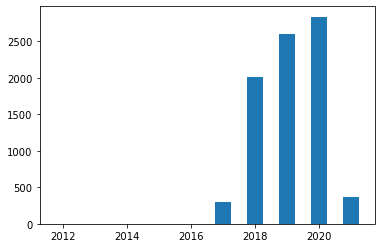

In [354]:
dates = UShousing1[['start_date']].dropna()
dates = pd.to_datetime(dates['start_date'],format = '%Y-%m-%d')
dates = dates.to_frame()
dates_cleaned = dates[dates.start_date < pd.to_datetime('2021-12-31',format = '%Y-%m-%d')]
# dates_cleaned.describe()
dates_cleaned['year'] = pd.DatetimeIndex(dates_cleaned['start_date']).year
# dates_cleaned['year'].plot.hist(color = 'green',alpha = 0.8)
# dates_cleaned['year'].plot.hist(color = 'green',alpha = 0.8)
y = dates_cleaned.groupby(['year']).count()['start_date']
arr = plt.bar(x = y.index,height=y, width=0.5, label = True)

##### Location

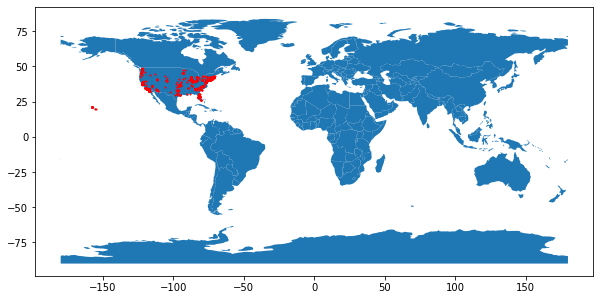

In [355]:
# https://stackoverflow.com/questions/53233228/plot-latitude-longitude-from-csv-in-python-3-6
geometry = [Point(xy) for xy in zip(UShousing1['longitude'], UShousing1['latitude'])]
gdf = GeoDataFrame(UShousing1, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=1)

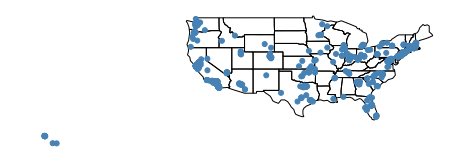

In [356]:
# https://residentmario.github.io/geoplot/quickstart/quickstart.html
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))
# gplt.polyplot(contiguous_usa)
ax = gplt.polyplot(contiguous_usa)
gplt.pointplot(gdf, ax=ax)

##### Correlation analysis

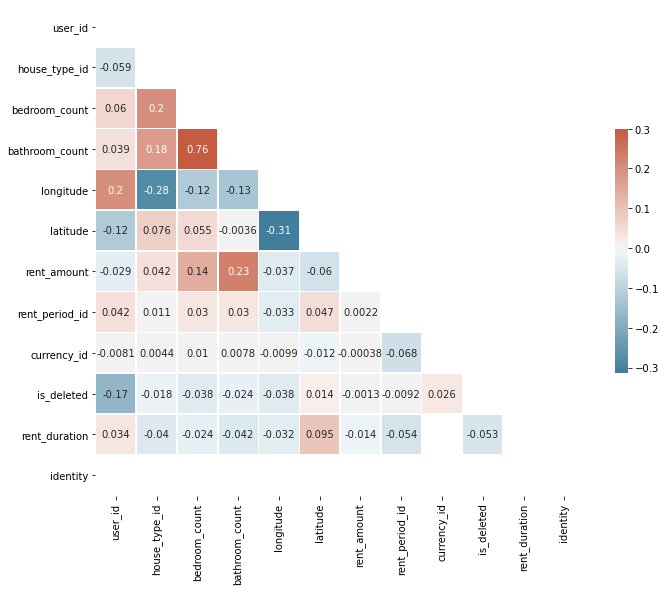

In [357]:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html

# sns.set_theme(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)

# Compute the correlation matrix
corr = UShousing1.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

##### Prediction distribution

Delete outliers for rent amount

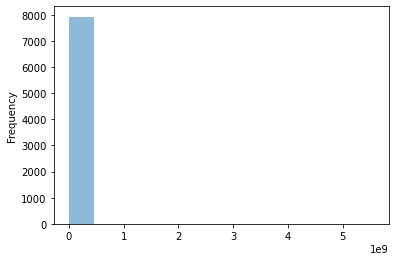

In [358]:
UShousing1["rent_amount"].plot.hist(bins=12, alpha=0.5)

In [359]:
UShousing1 = UShousing1[UShousing1.rent_amount < 30000]

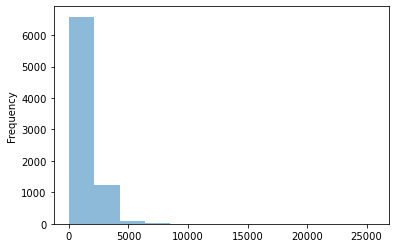

In [360]:
UShousing1["rent_amount"].plot.hist(bins=12, alpha=0.5)

Distribution based on different features

In [361]:
numdf = UShousing1.select_dtypes(include=[np.number])
num_cols = numdf.columns
num_cols

Index(['user_id', 'house_type_id', 'bedroom_count', 'bathroom_count',
       'longitude', 'latitude', 'rent_amount', 'rent_period_id', 'currency_id',
       'is_deleted', 'rent_duration', 'identity'],
      dtype='object')

house_type_id


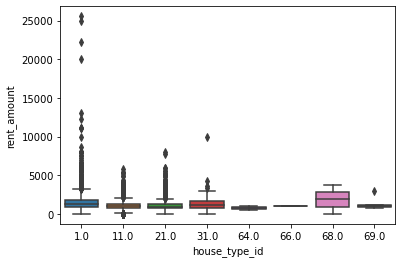

In [362]:
#Provide some examples due to time limit
for col in num_cols[1:2]:
    print(col)
    sns.boxplot(x=col, y="rent_amount", data=UShousing1)
    plt.show()

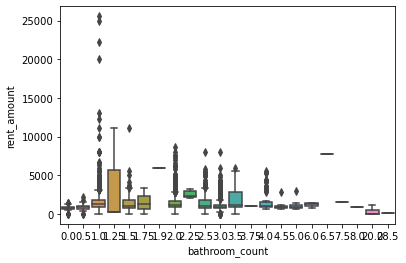

In [363]:
sns.boxplot(x="bathroom_count", y="rent_amount", data=UShousing1)
# plt.figure(figsize=(,100))
plt.show()

In [364]:
cols = UShousing1.columns

cate_cols = list(set(cols) - set(num_cols))
cate_cols

['State_geo',
 'publisher_identity',
 'is_banner',
 'description_falg',
 'update_utc_time',
 'Country_geo',
 'geometry',
 'start_date',
 'create_time',
 'City_geo',
 'update_time',
 'timezone',
 'agent_flag',
 'map_type',
 'is_blocked',
 'weight',
 'Postcode_geo',
 'facility_flag',
 'language',
 'is_shared',
 'base_info_flag',
 'rent_flag',
 'is_published']

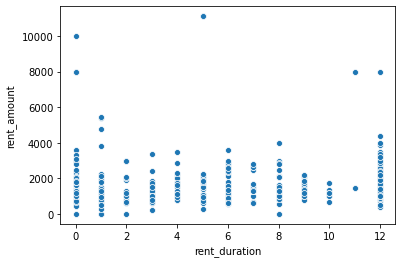

In [365]:
sns.scatterplot(x="rent_duration", y="rent_amount", data=UShousing1)
plt.show()

Export data

In [367]:
UShousing1.to_csv('UShousing1.csv', index=False)
UShousing1.shape

(7919, 35)